In [1]:
# Imports
import zstandard as zstd
import json
import os
import io
from tqdm import tqdm

from einops import rearrange
import torch as t
from nnsight import LanguageModel
from dictionary_learning.buffer import ActivationBuffer
from dictionary_learning.dictionary import AutoEncoder
from dictionary_learning.training import trainSAE

import matplotlib.pyplot as plt
import imageio
from circuitsvis.activations import text_neuron_activations

/home/can/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Experiment setup

In [2]:
ACTIVATION_DIM = 512
DICTIONARY_SIZE = 64 * ACTIVATION_DIM # This is the dict_size sam mostly works with.
EPS = 1e-8

In [3]:
model = LanguageModel('EleutherAI/pythia-70m-deduped', device_map='cuda:0')
submodules = [
    layer.mlp for layer in model.gpt_neox.layers
]

dictionaries = []
for i in range(len(submodules)):
    dictionary = AutoEncoder(ACTIVATION_DIM, DICTIONARY_SIZE).to('cuda:0')
    dictionary.load_state_dict(t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/mlp_out_layer{i}/1_32768/ae.pt'))
    dictionaries.append(dictionary)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
# set up data as a generator
data_path = '/share/data/datasets/pile/the-eye.eu/public/AI/pile/train/00.jsonl.zst'
compressed_file = open(data_path, 'rb')
dctx = zstd.ZstdDecompressor()
reader = dctx.stream_reader(compressed_file)
text_stream = io.TextIOWrapper(reader, encoding='utf-8')
def generator():
    for line in text_stream:
        yield json.loads(line)['text']
data = generator()

# Mean feature activation – random contexts
for final token prediction, one activation per prompt.

In [5]:
# Probs look at other interpretability measures from anthropic paper, too?

In [6]:
layer_acts_random = 5

In [7]:
# Buffer tied to one specific submodule!
buffer = ActivationBuffer(
    data,
    model,
    submodules[layer_acts_random],
    io='out',
    in_feats=ACTIVATION_DIM,
    out_feats=ACTIVATION_DIM,
    in_batch_size=512,
    out_batch_size=2 ** 15,
    n_ctxs=1e4,
)

# returns activations on dataset examples for the submodule specified
# for each example, activations per each token positon are concatenated along dim out_batch_size
acts = next(buffer) # [out_batch_size, activation_size]
acts.shape

refreshing buffer...


You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


buffer refreshed...


torch.Size([32768, 512])

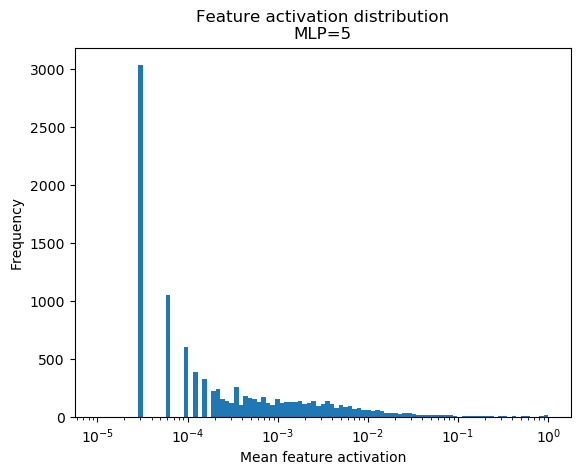

In [15]:
dict_acts_random = dictionaries[layer_acts_random].encode(acts.cuda()) # [batch, dictionary_size] 
mean_acts_random = (dict_acts_random !=0 ).sum(dim=0) / dict_acts_random.shape[0]

plt.figure()
plt.hist(mean_acts_random.cpu(), bins=t.logspace(-5, 0, 100))
plt.xscale('log')
plt.title(f'Feature activation distribution\nMLP={layer_acts_random}')
plt.xlabel('Mean feature activation')
plt.ylabel('Frequency');

In [9]:
# mean feature activation for multiple checkpoints
# make gif
def make_gif_mean_feat_activation():
    for checkpoint in range(0, 101000, 5000):
        ae = AutoEncoder(ACTIVATION_DIM, DICTIONARY_SIZE).cuda()
        ae.load_state_dict(
            t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/mlp_out_layer{layer_acts_random}/1_{DICTIONARY_SIZE}/checkpoints/ae_{checkpoint}.pt')
        )

        dict_acts = ae.encode(acts.cuda())
        freqs = (dict_acts !=0).sum(dim=0) / dict_acts.shape[0]

        plt.figure()
        plt.hist(freqs.cpu(), bins=t.logspace(-5, 0, 100))
        plt.xscale('log')
        plt.title(f'Layer {layer_acts_random} - checkpoint {checkpoint}, 1_32768')
        plt.savefig(f'junk/{checkpoint}_hist.png')
        plt.close()
    
    images = [
        imageio.imread(f'junk/{checkpoint}_hist.png')
        for checkpoint in range(0, 103000, 5000)
    ]
    imageio.mimsave('junk/hist.gif', images, fps=1)

# Mean feature activation – coherent contexts

mean over batch and token_position

In [8]:
tokenized_prompts = buffer.tokenized_batch(batch_size=512) # [batch, n_ctx]

In [9]:
# Get feature activations from autoencoder
def get_feature_activations(layer):
    '''
    Function for retrieving feature activations from tokenized batch
    returns activations for all submodules, dictionaries if layer == None
    
    '''
    with model.generate(max_new_tokens=1, pad_token_id=model.tokenizer.pad_token_id) as generator:
        with generator.invoke(tokenized_prompts['input_ids'], scan=False) as invoker:
            hidden_states = submodules[layer].output.save() # hidden_states.value: [batch, n_ctx, d_mlp]
    dictionary_activation = dictionaries[layer].encode(hidden_states.value)
    return dictionary_activation
    # else:
    #     dictionary_activations = []
    #     with model.generate(max_new_tokens=1, pad_token_id=model.tokenizer.pad_token_id) as generator:
    #         with generator.invoke(tokenized_prompts['input_ids'], scan=False) as invoker:
    #             for layer in range(len(submodules)):
    #                 x = submodules[layer].output
    #                 f = dictionaries[layer].encode(x).save()
    #                 dictionary_activations.append(f)
    #     return dictionary_activations

### Analyze frequencies in second mode
Second mode refers to the smaller frequency peak usually above 1e-2 in mean feature activations.

In [10]:
layer_acts_coherent = 5

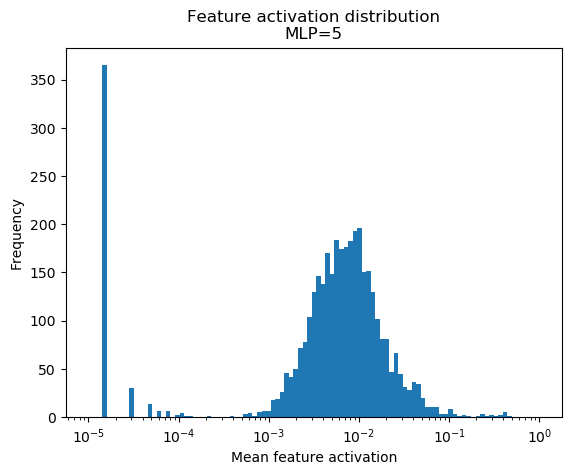

In [11]:
dict_acts_coherent = get_feature_activations(layer_acts_coherent)
flattened_acts_coherent = rearrange(dict_acts_coherent, 'b n d -> (b n) d')
mean_activations = (flattened_acts_coherent !=0).sum(dim=0) / flattened_acts_coherent.shape[0] # [d_sae]

plt.figure()
plt.hist(mean_activations.cpu(), bins=t.logspace(-5, 0, 100))
plt.xscale('log')
plt.title(f'Feature activation distribution\nMLP={layer_acts_random}');
plt.xlabel('Mean feature activation')
plt.ylabel('Frequency');

In [12]:
topk_mean_activations_coherent = sorted(enumerate(mean_activations), key=lambda x: x[1].abs(), reverse=True)
for i, eff in topk_mean_activations_coherent[:10]:
    print(f'layer {layer_acts_coherent}\t feat {i}:\t {eff}')

layer 5	 feat 6381:	 0.4892425537109375
layer 5	 feat 29434:	 0.4373626708984375
layer 5	 feat 22606:	 0.4359893798828125
layer 5	 feat 23543:	 0.4336395263671875
layer 5	 feat 16556:	 0.431732177734375
layer 5	 feat 26992:	 0.416595458984375
layer 5	 feat 26716:	 0.38433837890625
layer 5	 feat 32034:	 0.355926513671875
layer 5	 feat 9746:	 0.3291473388671875
layer 5	 feat 8395:	 0.293304443359375


Manually setting interval for second peak could be improved with interactive click and drag interval. plotly?

## Visualize prompts with highest activation for given feature

In [13]:
feature_id_coherent = 1202

In [14]:
def list_decode(x):
    if isinstance(x, int):
        return model.tokenizer.decode(x)
    else:
        return [list_decode(y) for y in x]
    
def topk_prompts_provider(feature_layer: int, feature_id: int, k: int = 30):
    # Sort examples in batch by max feature activation
    dictionary_activations = get_feature_activations(feature_layer)
    acts = dictionary_activations[:, :, feature_id].cpu() # acts: [batch, pos]
    flattened_acts = rearrange(acts, 'b l -> (b l)')
    topk_indices = t.argsort(flattened_acts, dim=0, descending=True)[:k] 
    batch_indices = topk_indices // acts.shape[1]
    token_indices = topk_indices % acts.shape[1]

    # Visualize
    tokens = [
    tokenized_prompts['input_ids'][batch_idx, :token_idx+1].tolist() for batch_idx, token_idx in zip(batch_indices, token_indices)
    ]
    tokens = list_decode(tokens)
    activations = [
        acts[batch_idx, :token_id+1, None, None] for batch_idx, token_id in zip(batch_indices, token_indices)
    ]
    return tokens, activations

In [ ]:
tokens, activations = topk_prompts_provider(feature_layer=layer_acts_coherent, feature_id=feature_id_coherent)
text_neuron_activations(tokens, activations)

# Plural feature (testing acdc.py)
## Setup

In [15]:
# Create toy dataset
patch = (
    "The man", " is"
)
clean = (
    "The men", " are"
)
plural_token_pos = 1

tok = lambda x: t.tensor(model.tokenizer.encode(x))
toy_dataset = [dict(
    clean_prefix=tok(clean[0]),
    clean_answer=tok(clean[1]),
    patch_prefix=tok(patch[0]),
    patch_answer=tok(patch[1]),

)]

toy_dataset[0]['clean_prefix']

tensor([ 510, 1821])

## Patching on y

In [16]:
layer_patching_on_y = 5

In [17]:
from acdc import patching_on_y

effects, total_effect = patching_on_y(
    toy_dataset,
    model,
    submodules,
    dictionaries,
    method='all-folded'
)
plural_effect = effects[submodules[layer_patching_on_y]][plural_token_pos].detach().cpu()

print(f'total metric diff after replacing clean prefix with patch prefix: {total_effect}')

total metric diff after replacing clean prefix with patch prefix: 8.8028564453125


In [18]:
# TopK features with highest mean activation
topk_effects = sorted(enumerate(plural_effect), key=lambda x: x[1].abs(), reverse=True)

topk_features = []
for i, eff in topk_effects[:10]:
    topk_features.append(i)
    print(f'feat {i}:\t {eff}')

feat 22167:	 0.2865937054157257
feat 21277:	 0.12576480209827423
feat 10880:	 0.10416737198829651
feat 14747:	 0.10214502364397049
feat 13505:	 0.07417690753936768
feat 7352:	 0.053832706063985825
feat 27530:	 -0.053781237453222275
feat 22606:	 0.031817931681871414
feat 30204:	 0.0313369482755661
feat 8810:	 -0.024746902287006378


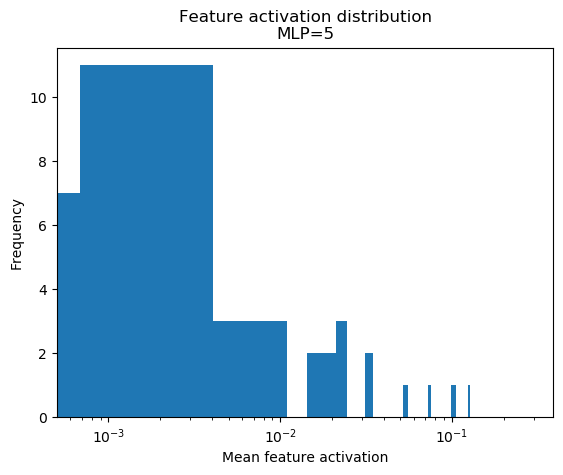

In [19]:
plt.figure()
plt.hist(plural_effect[plural_effect.abs() > EPS], bins=100)
plt.xscale('log')
plt.title(f'Feature activation distribution\nMLP={layer_patching_on_y}');
plt.xlabel('Mean feature activation')
plt.ylabel('Frequency');

In [20]:
tokens, activations = topk_prompts_provider(feature_layer=layer_patching_on_y, feature_id=topk_features[0])
text_neuron_activations(tokens, activations)

## Patching on feature activation

In [21]:
downstream_feat_layer = 5
downstream_feat_id = 22167 #5/22167 seems to activate on singular nouns related do people

k_upstream_feats = 3

In [22]:
from acdc import patching_on_feature_activation
effects, total_effect = patching_on_feature_activation(
    toy_dataset,
    model,
    submodules,
    dictionaries,
    downstream_feature_layer=downstream_feat_layer,
    downstream_feature_id=downstream_feat_id, 
    method='all-folded'
)

print(f'total metric diff after replacing clean prefix with patch prefix: {total_effect}')

total metric diff after replacing clean prefix with patch prefix: 2.389716148376465


In [23]:
topk_upstream_feats = t.zeros((len(submodules), k_upstream_feats))

for layer in range(len(submodules)):
    print(f'\n\nLayer {layer}:')
    plural_effect = effects[submodules[layer]][plural_token_pos].detach().cpu()

    # TopK features with highest mean activation
    topk_effects = sorted(enumerate(plural_effect), key=lambda x: x[1].abs(), reverse=True)
    topk_features[layer] = topk_effects[:3]
    for id, eff in topk_effects[:3]:
        print(f'feat {id}:\t {eff}')



Layer 0:
feat 20987:	 1.8057266473770142
feat 15149:	 -1.320497751235962
feat 0:	 0.0


Layer 1:
feat 16149:	 0.181435227394104
feat 14400:	 -0.03838137537240982
feat 25045:	 0.028566457331180573


Layer 2:
feat 8734:	 0.04685451462864876
feat 4770:	 0.024982599541544914
feat 31615:	 -0.010588026605546474


Layer 3:
feat 26928:	 -0.09890806674957275
feat 22260:	 0.03759358078241348
feat 21615:	 0.03652147948741913


Layer 4:
feat 25647:	 0.13976886868476868
feat 26810:	 0.08913157135248184
feat 16301:	 0.0890531912446022


Layer 5:
feat 22167:	 2.013801336288452
feat 10880:	 0.06829008460044861
feat 7352:	 -0.056569550186395645


Exact patching should yield 0 unconnected features in same or later layer. (No bwdpass involved)

In [29]:
tokens, activations = topk_prompts_provider(
    feature_layer=3,
    feature_id=26928,
    k=5
)
text_neuron_activations(tokens, activations)